# RGB to GrayScale AutoEncoder
In this project, we are going to test the power of AutoEncoder for converting the RGB images to grayscale.

In [1]:
#installation of opencv
!pip install opencv-python

    100% |████████████████████████████████| 28.3MB 1.5MB/s eta 0:00:01
fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import cv2
import glob 

count = 0

path_daisy = 'flower_photos/daisy/*.jpg'
path_dandelion = 'flower_photos/dandelion/*.jpg'
path_roses = 'flower_photos/roses/*.jpg'
path_sunflowers = 'flower_photos/sunflowers/*.jpg'
path_tulips = 'flower_photos/tulips/*.jpg'

paths_list = [path_daisy, path_dandelion, path_roses, path_sunflowers, path_tulips]

for path in paths_list:
    
    filenames = glob.glob(path)

    for filename in filenames:
        
        image = cv2.imread(filename)
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        image = cv2.resize(image, (128, 128))
        gray_img = cv2.resize(gray_img, (128, 128))
    
        cv2.imwrite("new_gray_images/1/gray_" +str(count) +".png", gray_img)
        cv2.imwrite("new_color_images/1/color_" +str(count) +".png", image)
    
        count += 1
       
        if count == 32*114:
            break

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FlowerAutoEncoder(nn.Module):
    def __init__(self):
        super(FlowerAutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv4 = nn.Conv2d(64, 32, 3, padding = 1)
        ## 128 -> 64 -> 32 -> 16 
        self.pool = nn.MaxPool2d(2, 2)
        
        self.t_conv1 = nn.ConvTranspose2d(32, 64, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 1, 2, stride=2)
        ## 16 -> 32 -> 64 -> 128
        
    def forward(self, x):
#        x.view(x.size(0))
        x = F.relu(self.conv1(x))
        x = self.pool(x) #128 -> 64
        x = F.relu(self.conv2(x))
        x = self.pool(x) #64 -> 32
        x = F.relu(self.conv3(x)) ## 32 -> 32
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)   #32 -> 16
        
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = torch.sigmoid(self.t_conv3(x))        
        return x
    
model = FlowerAutoEncoder()
print(model)

FlowerAutoEncoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [73]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [74]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [7]:
gray_transform = transforms.Compose([ 
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor()
                            
                               ])

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
                               ])


color_imgs = datasets.ImageFolder('new_color_images/', transform= transform)
gray_imgs  = datasets.ImageFolder('new_gray_images/', transform= gray_transform)
color_train_loader = DataLoader(dataset=color_imgs, batch_size=32, shuffle=False, num_workers=0)
gray_train_loader  = DataLoader(dataset=gray_imgs,  batch_size=32, shuffle=False, num_workers=0)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
model.cuda()

FlowerAutoEncoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [11]:
total_epochs = 50
for epoch in range(total_epochs +1):
    train_loss =0.0
    for i, data in enumerate(zip(color_train_loader, gray_train_loader)):
        color_imgs, _ = data[0]
        gray_imgs, _  = data[1]
        color_imgs = color_imgs.cuda()
        gray_imgs = gray_imgs.cuda()
        optimizer.zero_grad()                #Z
        outputs = model(color_imgs)           #M
        loss = criterion(outputs, gray_imgs) #C
        loss.backward()                      #B
        optimizer.step()                     #S
        train_loss += loss.item()*len(color_imgs)
        
    print("Epoch: ",epoch," Final Loss: ",train_loss/len(color_train_loader))

Epoch:  0  Final Loss:  0.9203942112232509
Epoch:  1  Final Loss:  0.4040473487816359
Epoch:  2  Final Loss:  0.3467199151453219
Epoch:  3  Final Loss:  0.31700021616722407
Epoch:  4  Final Loss:  0.2984521605989389
Epoch:  5  Final Loss:  0.2847053897485398
Epoch:  6  Final Loss:  0.27453020803238215
Epoch:  7  Final Loss:  0.26675635380180257
Epoch:  8  Final Loss:  0.25995883188749613
Epoch:  9  Final Loss:  0.25426932659588364
Epoch:  10  Final Loss:  0.24971079264293639
Epoch:  11  Final Loss:  0.24582257873395033
Epoch:  12  Final Loss:  0.24222366694818465
Epoch:  13  Final Loss:  0.238618712349419
Epoch:  14  Final Loss:  0.23554319731499018
Epoch:  15  Final Loss:  0.23283574592910314
Epoch:  16  Final Loss:  0.23007999262527415
Epoch:  17  Final Loss:  0.22728504887536952
Epoch:  18  Final Loss:  0.22495430949748607
Epoch:  19  Final Loss:  0.2225388406138671
Epoch:  20  Final Loss:  0.22030511204349368
Epoch:  21  Final Loss:  0.21875672493326037
Epoch:  22  Final Loss:  0.2

In [12]:
torch.save(model.state_dict(), 'working/model.state')

In [13]:
model.load_state_dict(torch.load('working/model.state'))

<All keys matched successfully>

In [12]:
test_color_imgs = datasets.ImageFolder('flower_images/', transform= transform)
color_test_loader = DataLoader(dataset=test_color_imgs, batch_size=32, shuffle=False, num_workers=0)

In [20]:
import os
import glob
img_dir = "flower_images/flower_images/" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)

In [61]:
from PIL import Image
def generate_gray_flowers(img_path):
    img = cv2.imread(img_path)


    image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])
    img = image_transform(img).unsqueeze(0)
    img = img.cuda()

    model.eval()
    with torch.no_grad():
        new_gray_img = model.forward(img)
    
    gen_img = new_gray_img.cpu().detach().numpy() 
    gen_img = np.squeeze(gen_img, axis=0)
    gen_img = np.squeeze(gen_img, axis=0)
    
    plt.imshow(gen_img, cmap='gray')


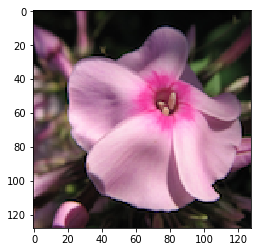

In [69]:
import matplotlib.image as mpimg
img=mpimg.imread(files[2])
plt.imshow(img)


### Retraining of model for more epochs

In [70]:
model.train()
total_epochs = 5
for epoch in range(total_epochs +1):
    train_loss =0.0
    for i, data in enumerate(zip(color_train_loader, gray_train_loader)):
        color_imgs, _ = data[0]
        gray_imgs, _  = data[1]
        color_imgs = color_imgs.cuda()
        gray_imgs = gray_imgs.cuda()
        optimizer.zero_grad()                #Z
        outputs = model(color_imgs)           #M
        loss = criterion(outputs, gray_imgs) #C
        loss.backward()                      #B
        optimizer.step()                     #S
        train_loss += loss.item()*len(color_imgs)
        
    print("Epoch: ",epoch," Final Loss: ",train_loss/len(color_train_loader))

Epoch:  0  Final Loss:  0.18994408061629847
Epoch:  1  Final Loss:  0.18920899450517537
Epoch:  2  Final Loss:  0.18831643253041988
Epoch:  3  Final Loss:  0.18734297829500415
Epoch:  4  Final Loss:  0.18690355651472745
Epoch:  5  Final Loss:  0.1862898602950991


Let's try to lower down the learning rate

In [71]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [72]:
model.train()
total_epochs = 20
for epoch in range(total_epochs +1):
    train_loss =0.0
    for i, data in enumerate(zip(color_train_loader, gray_train_loader)):
        color_imgs, _ = data[0]
        gray_imgs, _  = data[1]
        color_imgs = color_imgs.cuda()
        gray_imgs = gray_imgs.cuda()
        optimizer.zero_grad()                #Z
        outputs = model(color_imgs)           #M
        loss = criterion(outputs, gray_imgs) #C
        loss.backward()                      #B
        optimizer.step()                     #S
        train_loss += loss.item()*len(color_imgs)
        
    print("Epoch: ",epoch," Final Loss: ",train_loss/len(color_train_loader))

Epoch:  0  Final Loss:  0.18429332716684593
Epoch:  1  Final Loss:  0.18387674304999804
Epoch:  2  Final Loss:  0.18371672202882014
Epoch:  3  Final Loss:  0.18356248808273098
Epoch:  4  Final Loss:  0.18339908306013075
Epoch:  5  Final Loss:  0.18323706861650735
Epoch:  6  Final Loss:  0.18307774115288467
Epoch:  7  Final Loss:  0.18292182919226194
Epoch:  8  Final Loss:  0.18276793869179592
Epoch:  9  Final Loss:  0.18261654165230298
Epoch:  10  Final Loss:  0.18246817693375705
Epoch:  11  Final Loss:  0.18232272545758046
Epoch:  12  Final Loss:  0.1821797460056188
Epoch:  13  Final Loss:  0.18203914864805706
Epoch:  14  Final Loss:  0.18190064960927294
Epoch:  15  Final Loss:  0.18176487035918654
Epoch:  16  Final Loss:  0.1816312744559949
Epoch:  17  Final Loss:  0.18149945512413979
Epoch:  18  Final Loss:  0.18137013709597422
Epoch:  19  Final Loss:  0.18124302326325784
Epoch:  20  Final Loss:  0.18111712328697505


In [75]:
model.train()
total_epochs = 100
for epoch in range(total_epochs +1):
    train_loss =0.0
    for i, data in enumerate(zip(color_train_loader, gray_train_loader)):
        color_imgs, _ = data[0]
        gray_imgs, _  = data[1]
        color_imgs = color_imgs.cuda()
        gray_imgs = gray_imgs.cuda()
        optimizer.zero_grad()                #Z
        outputs = model(color_imgs)           #M
        loss = criterion(outputs, gray_imgs) #C
        loss.backward()                      #B
        optimizer.step()                     #S
        train_loss += loss.item()*len(color_imgs)
        
    print("Epoch: ",epoch," Final Loss: ",train_loss/len(color_train_loader))

Epoch:  0  Final Loss:  0.1812868989481215
Epoch:  1  Final Loss:  0.1808660112059953
Epoch:  2  Final Loss:  0.18080052779170505
Epoch:  3  Final Loss:  0.18070992716310316
Epoch:  4  Final Loss:  0.18061118827838646
Epoch:  5  Final Loss:  0.18050516194157434
Epoch:  6  Final Loss:  0.18039991209904352


KeyboardInterrupt: 

In [76]:
torch.save(model.state_dict(), 'working/model1.state')

In [77]:
model.load_state_dict(torch.load('working/model1.state'))

<All keys matched successfully>

In [78]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
total_epochs = 100
for epoch in range(total_epochs +1):
    train_loss =0.0
    for i, data in enumerate(zip(color_train_loader, gray_train_loader)):
        color_imgs, _ = data[0]
        gray_imgs, _  = data[1]
        color_imgs = color_imgs.cuda()
        gray_imgs = gray_imgs.cuda()
        optimizer.zero_grad()                #Z
        outputs = model(color_imgs)           #M
        loss = criterion(outputs, gray_imgs) #C
        loss.backward()                      #B
        optimizer.step()                     #S
        train_loss += loss.item()*len(color_imgs)
        
    print("Epoch: ",epoch," Final Loss: ",train_loss/len(color_train_loader))

Epoch:  0  Final Loss:  0.21743603697732874
Epoch:  1  Final Loss:  0.18172139694031916
Epoch:  2  Final Loss:  0.1814684786163924
Epoch:  3  Final Loss:  0.18131288781500698
Epoch:  4  Final Loss:  0.18210254688011973
Epoch:  5  Final Loss:  0.18080622532911467
Epoch:  6  Final Loss:  0.18073323976836705
Epoch:  7  Final Loss:  0.18102880371244331
Epoch:  8  Final Loss:  0.1801725469137493
Epoch:  9  Final Loss:  0.1801909618733222
Epoch:  10  Final Loss:  0.18019403059754455
Epoch:  11  Final Loss:  0.17936005240731073
Epoch:  12  Final Loss:  0.1798446603903645
Epoch:  13  Final Loss:  0.17882258941729864
Epoch:  14  Final Loss:  0.17916266960010194
Epoch:  15  Final Loss:  0.1783581609396558
Epoch:  16  Final Loss:  0.17891079984736025
Epoch:  17  Final Loss:  0.1777372958236619
Epoch:  18  Final Loss:  0.17805445893553265
Epoch:  19  Final Loss:  0.17735125614624275
Epoch:  20  Final Loss:  0.1771077916941099
Epoch:  21  Final Loss:  0.176849916969475
Epoch:  22  Final Loss:  0.17

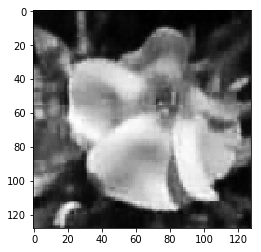

In [79]:
generate_gray_flowers(files[2])

In [80]:
torch.save(model.state_dict(), 'working/modelfinal.state')

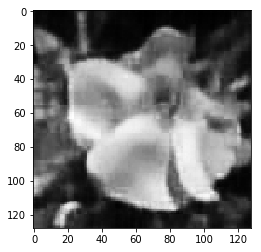

In [64]:
generate_gray_flowers(files[2])